### **IMPORT NECESSARY LIBRARY**


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle, math

# Weights file names
bert_weight_name = 'bert-base-uncased'
t5_weight_name = 'google-t5-small'

### **LOADING THE WEIGHTS OF PRETRAINED MODEL**


In [2]:
# Loading bert model
with open(f'../saved/weights_only/{bert_weight_name}_weights.pkl','rb') as file:
    bert_weights_dict = pickle.load(file)

with open(f'../saved/weights_only/{t5_weight_name}_weights.pkl','rb') as file:
    t5_weights_dict = pickle.load(file)          

### **FUNCTION DECLARATIONS**


In [4]:
# Forward pass for given input and weight (bias not included)
def forwPass(X, w):
    return X@w.T

# Computing l2 loss for two results
def l2loss(processed_y, true_y):
    return np.sum((true_y - processed_y)**2)

# Computing l1 loss for two results
def l1loss(processed_y, true_y):
    return np.sum(np.abs(true_y - processed_y))

In [5]:
# Finding losses for different magnitude threshold
def loss_mag_thres(X, w, true_y, callbacklossfn, step = 0.001 ):
    abs_max = max(np.abs(np.min(w)), np.abs(np.max(w)))
    points = abs_max/step

    mags = list(np.linspace(0, abs_max, num= int(points), endpoint=False))
    mags = mags[:int(len(mags)/2)]
    losses = []
    
    for mag in mags:
        w[(w < mag) & (w > -mag)] = 0
        y = forwPass(X, w)
        loss = callbacklossfn(y, true_y)   
        losses.append(loss)

    return mags, losses

In [6]:
# Finding losses for different range threshold
def loss_ran_thres(X, w, true_y, callbacklossfn, step = 0.001 ):

    local_min = np.min(w)
    local_max = np.max(w)
    points = (local_max - local_min)/step

    mags = list(np.linspace(local_min/2, local_max/2, num= int(points), endpoint=False))[:-1]
    # mags = mags[:int(len(mags)/2)]
    losses = []
    
    for mag in mags:
        w[(w < mag)] = 0
        
        y = forwPass(X, w)
        loss = callbacklossfn(y, true_y)
        
        losses.append(loss)

    return mags, losses

### **WEIGHT DISTRIBUTION OF RANDOMLY SELECTED LAYER**


#### **WEIGHT**


Mean of the distribution:  9.540911e-06
Standard Deviation:  0.03540624
Shape of the weights:  (768, 768)


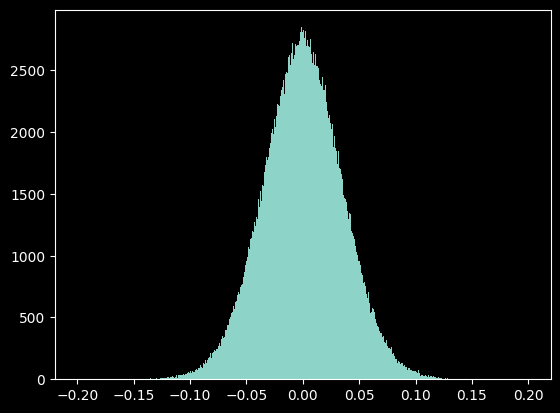

In [6]:
individual_weight = bert_weights_dict['encoder.layer.8.attention.self.value.weight']
individual_weight = individual_weight.flatten()
print("Mean of the distribution: ", np.mean(individual_weight))
print("Standard Deviation: ", np.std(individual_weight))
print("Shape of the weights: ", bert_weights_dict['encoder.layer.8.attention.self.value.weight'].shape)

plt.hist(individual_weight, range=(-0.2, 0.2), bins=1000)
plt.show()  

Mean of the distribution:  0.00040050843


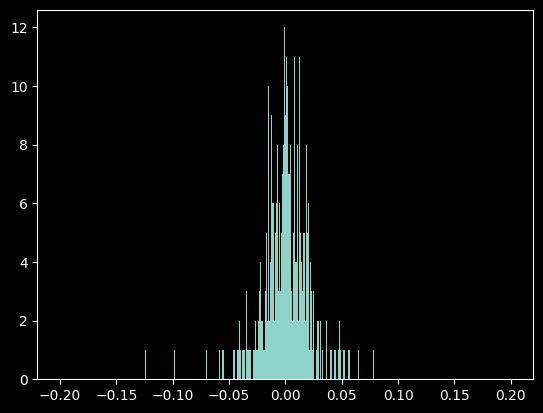

In [16]:
individual_weight = bert_weights_dict['encoder.layer.11.attention.self.value.bias']
individual_weight = individual_weight.flatten()
print("Mean of the distribution: ", np.mean(individual_weight))

plt.hist(individual_weight, range=(-0.2, 0.2), bins=1000)
plt.show()  

### **OBSERVING THE GLOBAL LARGEST AND SMALLEST WEIGHTS**


In [9]:
# largest and smallest weight in the model
g_max = (-1000000, '')
g_min = (1000000, '')
# Extracting the distribution of each layer weights
for index, item in enumerate(bert_weights_dict.items()):
    name, weights = item
    
    # Global minimum value and largest
    local_min = np.min(weights)
    local_max = np.max(weights)
    
    if local_min < g_min[0]:
        g_min = (local_min, name)
    
    if local_max > g_max[0]:
        g_max = (local_max, name)

print("Largest weight in the model: ", g_max[0], "\nLayer name: ", g_max[1]) 
print()
print("Smallest weight in the model: ", g_min[0], "\nLayer name: ", g_min[1]) 



Largest weight in the model:  3.7373548 
Layer name:  encoder.layer.4.attention.output.LayerNorm.weight

Smallest weight in the model:  -6.8175616 
Layer name:  encoder.layer.4.output.dense.weight


### **SINGLE LAYER**


Largest weight in the model:  0.28118798 
Smallest weight in the model:  -0.26224077

Mean of the distribution:  -2.2046783e-05


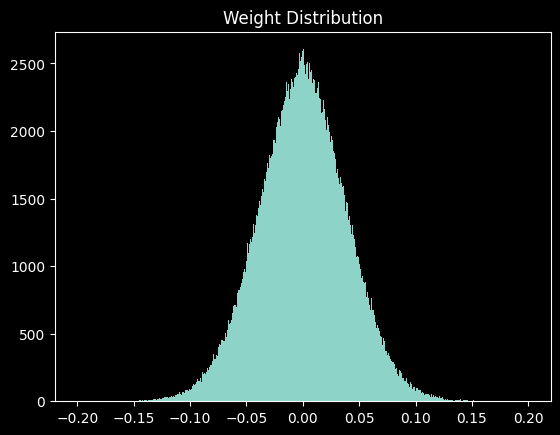

In [10]:
layer_weight = bert_weights_dict['encoder.layer.11.attention.self.value.weight']

np.random.seed(12321)
X = np.random.randn(1, layer_weight.shape[1])
# X = np.random.randint(1, 9, (1, layer_weight.shape[1]))
Y = forwPass(X, layer_weight)

local_max = np.max(layer_weight)
local_min = np.min(layer_weight)
print("Largest weight in the model: ", local_max, "\nSmallest weight in the model: ", local_min) 
 

flatten_weight = layer_weight.flatten()
print("\nMean of the distribution: ", np.mean(flatten_weight))

plt.hist(flatten_weight, range=(-0.2, 0.2), bins=1000)
plt.title("Weight Distribution")


plt.show()

Text(0, 0.5, 'loss')

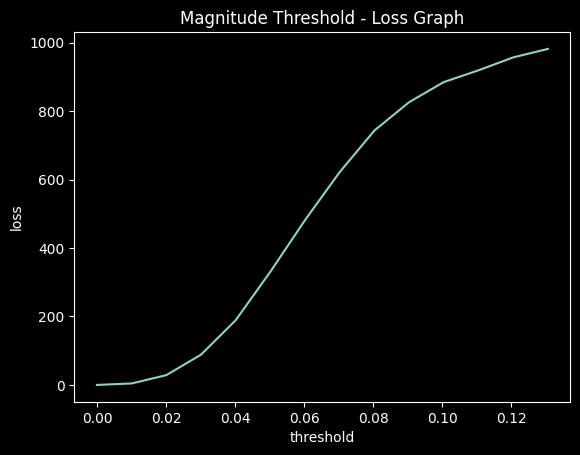

In [11]:
mag, losses = loss_mag_thres(X, layer_weight.copy(), Y, l2loss, step=0.01)

plt.plot(mag, losses)
plt.title("Magnitude Threshold - Loss Graph")
plt.xlabel("threshold")
plt.ylabel("loss")

Text(0, 0.5, 'loss')

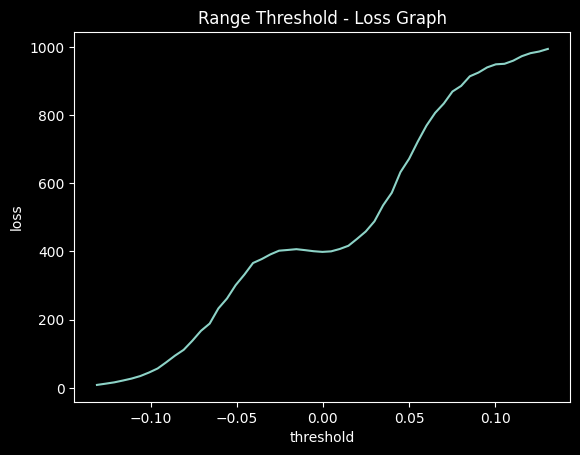

In [12]:
ran, losses = loss_ran_thres(X, layer_weight.copy(), Y, l2loss, step=0.01)

plt.plot(ran, losses)
plt.title("Range Threshold - Loss Graph")
plt.xlabel("threshold")
plt.ylabel("loss")

### **ALL LAYER IN THE MODEL**


Exception: Layer shared.weight is skipped


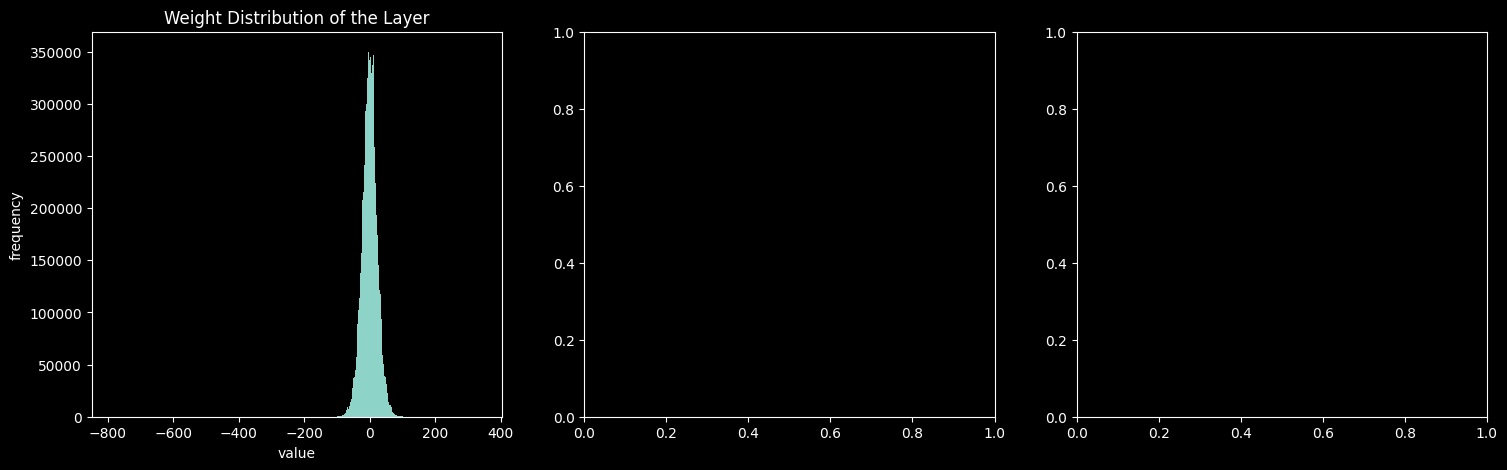

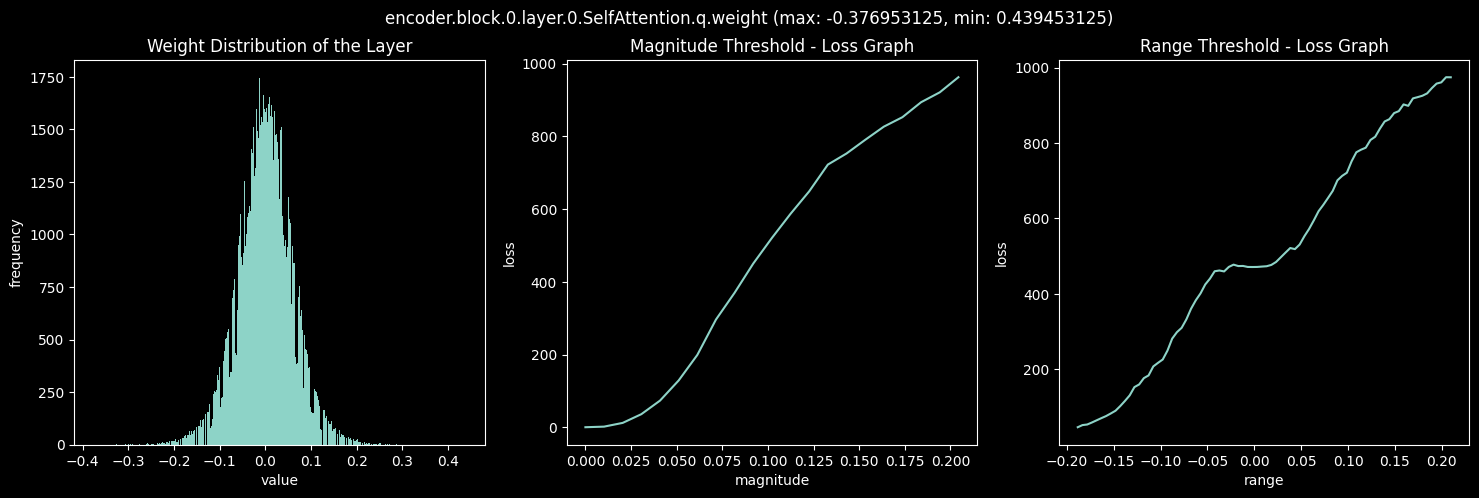

In [14]:
# model_dict = bert_weights_dict
model_dict = t5_weights_dict
for index, item in enumerate(model_dict.items()):

    name, layer_weight = item
    name_fig = name.replace('.', '_')

    try:
        if len(layer_weight.shape) != 2 or 'embeddings' in name:
            print(f"Layer {name} is skipped")
            continue

        fig, axs = plt.subplots(1, 3)
        fig.set_size_inches(18, 5)

        np.random.seed(12321)
        X = np.random.randn(1, layer_weight.shape[1])
        Y = forwPass(X, layer_weight)

        local_max = np.max(layer_weight)
        local_min = np.min(layer_weight)
        flatten_weight = layer_weight.flatten()

        axs[0].hist(flatten_weight, range=(local_min, local_max), bins=1000)
        axs[0].set_title("Weight Distribution of the Layer")
        axs[0].set_xlabel("value")
        axs[0].set_ylabel("frequency")

        mag, losses = loss_mag_thres(X, layer_weight.copy(), Y, l2loss, step=0.01)
        axs[1].plot(mag, losses)
        axs[1].set_title("Magnitude Threshold - Loss Graph")
        axs[1].set_xlabel('magnitude')
        axs[1].set_ylabel('loss')

        ran, losses = loss_ran_thres(X, layer_weight.copy(), Y, l2loss, step=0.01)
        axs[2].plot(ran, losses)
        axs[2].set_title("Range Threshold - Loss Graph")
        axs[2].set_xlabel('range')
        axs[2].set_ylabel('loss')

        fig.suptitle(f'{name} (min: {local_min}, max: {local_max})')
        fig.savefig(f'figures/t5/{index}_{name_fig}.png')
        plt.close(fig)
        
    except:
        print(f'Exception: Layer {name} is skipped')
